In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import copy

In [ ]:
# === 1. ฟังก์ชันตรวจสอบ dataset ===
def check_dataset(data_dir, classes=["T1","T2","T3","T4"]):
    img_ext = [".jpg",".jpeg",".png",".bmp"]
    missing_classes = []
    total_images = 0
    for cls in classes:
        folder = os.path.join(data_dir, cls)
        if not os.path.exists(folder):
            missing_classes.append(cls)
            continue
        files = [f for f in os.listdir(folder) if any(f.lower().endswith(ext) for ext in img_ext)]
        if len(files) == 0:
            missing_classes.append(cls)
        else:
            print(f"✅ {cls}: พบ {len(files)} ไฟล์")
            total_images += len(files)
    if missing_classes:
        print("Class ต่อไปนี้ไม่มีภาพหรือโฟลเดอร์หาย:", missing_classes)
    else:
        print("Dataset ครบทุก class แล้ว")
    print(f"รวมทั้งหมด {total_images} ไฟล์\n")
    return total_images, missing_classes

In [ ]:
# === 2. ตรวจสอบ dataset ===
data_dir = r"C:\wwwwd\Center New"
total_images, missing = check_dataset(data_dir)
if total_images == 0:
    raise RuntimeError("❌ ไม่พบไฟล์รูปภาพใน dataset เลย!")


✅ T1: พบ 272 ไฟล์
✅ T2: พบ 76 ไฟล์
✅ T3: พบ 41 ไฟล์
✅ T4: พบ 27 ไฟล์
Dataset ครบทุก class แล้ว
รวมทั้งหมด 416 ไฟล์



In [ ]:
# === 3. Data augmentation ===
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])


In [ ]:
# === 4. โหลด dataset และแบ่ง Train/Test ===
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)


In [ ]:
# === 5. โหลด VGG19 ===
vgg19 = models.vgg19(pretrained=False)  # ไม่ต้องโหลด weights เดิม
vgg19.classifier[6] = nn.Sequential(
    nn.Linear(4096, 1024), 
    nn.ReLU(), 
    nn.Dropout(0.5), 
    nn.Linear(1024, 4)
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg19 = vgg19.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg19.parameters(), lr=1e-4, weight_decay=1e-5)

C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# === 6. (Optional) YOLO segmentation ===
yolo_model = YOLO("best.pt")  # โหลด pretrained segmentation model (ยังไม่ใช้งานต่อ)

In [22]:
# ==========================
# 7. Training + Test + history
# ==========================
best_model_wts = copy.deepcopy(vgg19.state_dict())
best_acc = 0.0

train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(50):
    print(f"\nEpoch {epoch+1}/50")
    print("-"*20)
    # --- Train ---
    vgg19.train()
    running_loss, running_corrects = 0.0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vgg19(images)
        _, preds = torch.max(outputs,1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc.item())

    # --- Test ---
    vgg19.eval()
    test_loss, test_corrects = 0.0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = vgg19(images)
            _, preds = torch.max(outputs,1)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            test_corrects += torch.sum(preds == labels.data)
    test_loss = test_loss / len(test_dataset)
    test_acc = test_corrects.double() / len(test_dataset)
    test_losses.append(test_loss)
    test_accs.append(test_acc.item())

    print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}")

    # Update best weights
    if test_acc > best_acc:
        best_acc = test_acc
        best_model_wts = copy.deepcopy(vgg19.state_dict())
        print("✅ Model improved, saving best weights...")


Epoch 1/50
--------------------
Train Loss: 0.8132 Acc: 0.6807
Test Loss: 0.9081 Acc: 0.5476
✅ Model improved, saving best weights...

Epoch 2/50
--------------------
Train Loss: 0.7517 Acc: 0.7108
Test Loss: 0.9273 Acc: 0.6190
✅ Model improved, saving best weights...

Epoch 3/50
--------------------
Train Loss: 0.6711 Acc: 0.7711
Test Loss: 0.8879 Acc: 0.6786
✅ Model improved, saving best weights...

Epoch 4/50
--------------------
Train Loss: 0.5698 Acc: 0.7681
Test Loss: 0.9978 Acc: 0.6429

Epoch 5/50
--------------------
Train Loss: 0.5445 Acc: 0.7801
Test Loss: 0.9209 Acc: 0.7381
✅ Model improved, saving best weights...

Epoch 6/50
--------------------
Train Loss: 0.5119 Acc: 0.7982
Test Loss: 0.8550 Acc: 0.6905

Epoch 7/50
--------------------
Train Loss: 0.4143 Acc: 0.8193
Test Loss: 0.9192 Acc: 0.7619
✅ Model improved, saving best weights...

Epoch 8/50
--------------------
Train Loss: 0.4717 Acc: 0.8133
Test Loss: 1.0532 Acc: 0.6310

Epoch 9/50
--------------------
Train Loss

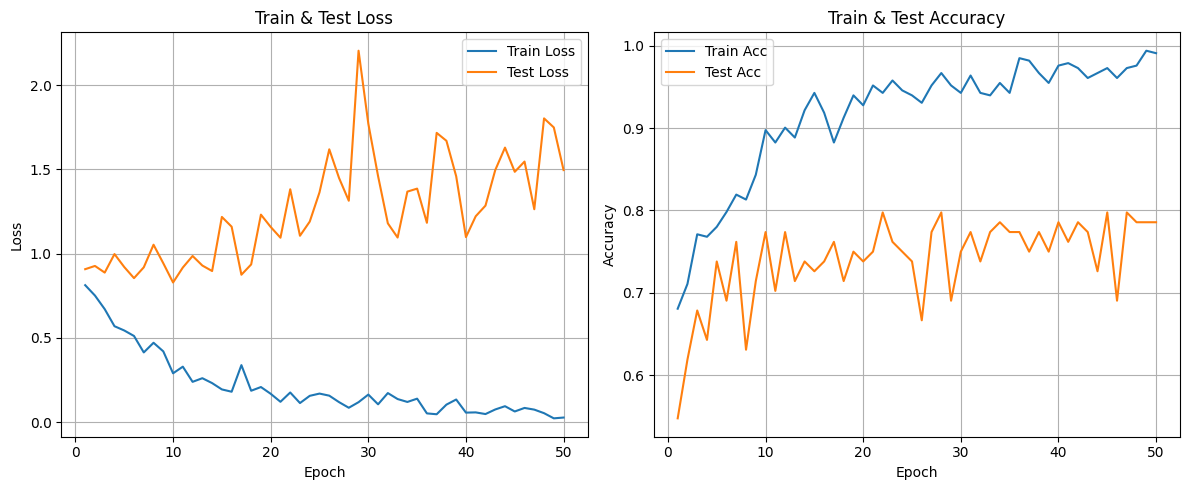

In [23]:
# ==========================
# 8. Plot Loss & Accuracy
# ==========================
epochs_range = range(1,len(train_losses)+1)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, train_losses,label='Train Loss')
plt.plot(epochs_range, test_losses,label='Test Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Train & Test Loss')
plt.legend(); plt.grid(True)
plt.subplot(1,2,2)
plt.plot(epochs_range, train_accs,label='Train Acc')
plt.plot(epochs_range, test_accs,label='Test Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Train & Test Accuracy')
plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()

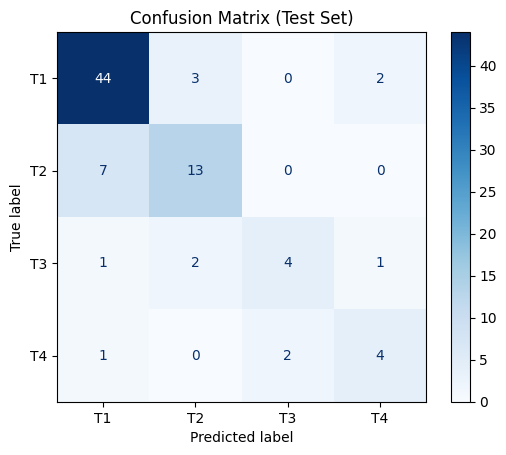

=== Evaluation Metrics (Test Set) ===
Accuracy: 0.7738
T1 → Precision: 0.8302, Recall: 0.8980, F1-score: 0.8627
T2 → Precision: 0.7222, Recall: 0.6500, F1-score: 0.6842
T3 → Precision: 0.6667, Recall: 0.5000, F1-score: 0.5714
T4 → Precision: 0.5714, Recall: 0.5714, F1-score: 0.5714

=== Classification Report ===
              precision    recall  f1-score   support

          T1       0.83      0.90      0.86        49
          T2       0.72      0.65      0.68        20
          T3       0.67      0.50      0.57         8
          T4       0.57      0.57      0.57         7

    accuracy                           0.77        84
   macro avg       0.70      0.65      0.67        84
weighted avg       0.77      0.77      0.77        84



In [24]:
# ==========================
# 9. Evaluation: Confusion Matrix & Metrics
# ==========================
vgg19.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vgg19(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

class_names = full_dataset.classes
y_true_labels = [class_names[i] for i in y_true]
y_pred_labels = [class_names[i] for i in y_pred]

# --- Confusion Matrix ---
cm = confusion_matrix(y_true_labels, y_pred_labels, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Test Set)")
plt.show()

# --- Metrics ---
accuracy = accuracy_score(y_true_labels, y_pred_labels)
precision = precision_score(y_true_labels, y_pred_labels, labels=class_names, average=None)
recall = recall_score(y_true_labels, y_pred_labels, labels=class_names, average=None)
f1 = f1_score(y_true_labels, y_pred_labels, labels=class_names, average=None)

print("=== Evaluation Metrics (Test Set) ===")
print(f"Accuracy: {accuracy:.4f}")
for i, cls in enumerate(class_names):
    print(f"{cls} → Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1-score: {f1[i]:.4f}")

print("\n=== Classification Report ===")
print(classification_report(y_true_labels, y_pred_labels, labels=class_names))

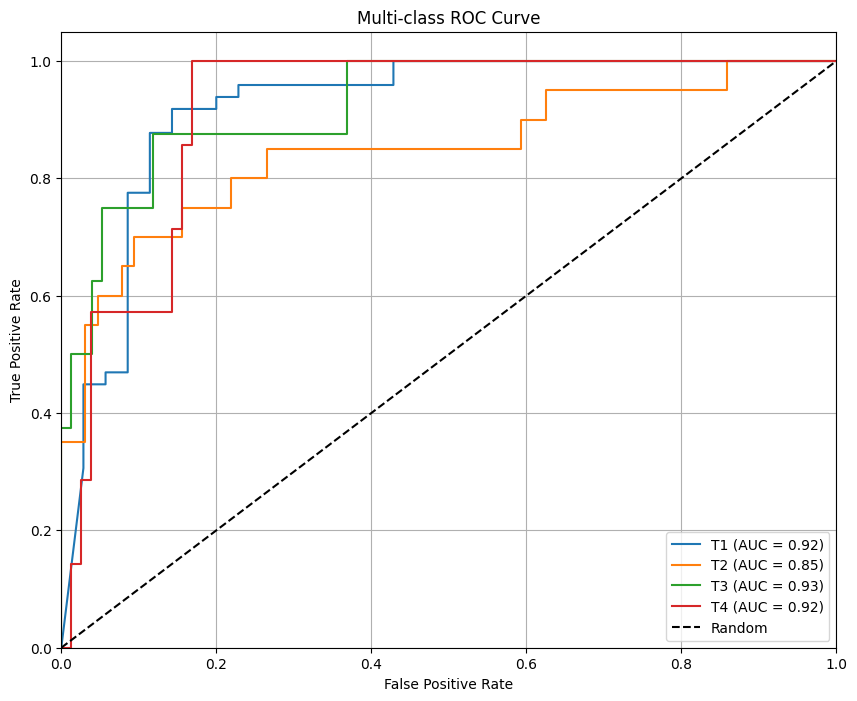

In [25]:
# ==========================
# 10. Multi-class ROC Curve
# ==========================
# One-hot encode true labels
y_true_onehot = label_binarize(y_true, classes=list(range(len(class_names))))
y_score = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = vgg19(images)
        probs = nn.functional.softmax(outputs, dim=1)
        y_score.extend(probs.cpu().numpy())

y_score = np.array(y_score)

plt.figure(figsize=(10,8))
for i, cls in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{cls} (AUC = {roc_auc:.2f})')

plt.plot([0,1],[0,1],'k--', label='Random')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

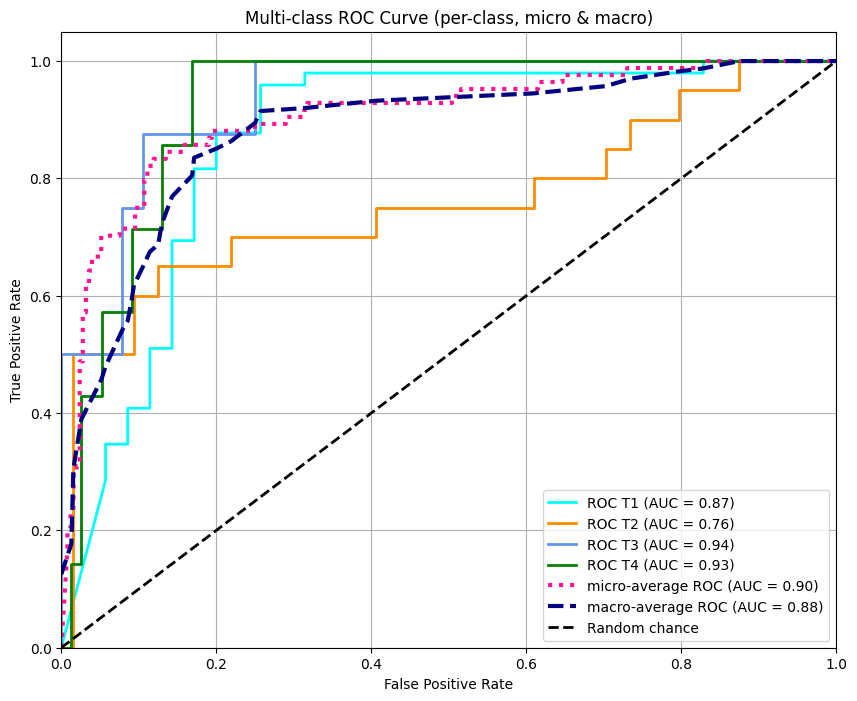

In [26]:
# ==========================
# 11. Multi-class ROC Curve (per-class + micro + macro)
# ==========================
y_true_onehot = label_binarize(y_true, classes=list(range(len(class_names))))
y_score = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = vgg19(images)
        probs = nn.functional.softmax(outputs, dim=1)
        y_score.extend(probs.cpu().numpy())

y_score = np.array(y_score)
n_classes = len(class_names)

# --- ROC per class ---
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# --- Micro-average ROC ---
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_onehot.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# --- Macro-average ROC ---
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# --- Plot ROC curves ---
plt.figure(figsize=(10,8))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=3,
         label=f'micro-average ROC (AUC = {roc_auc["micro"]:.2f})')
plt.plot(fpr["macro"], tpr["macro"], color='navy', linestyle='--', linewidth=3,
         label=f'macro-average ROC (AUC = {roc_auc["macro"]:.2f})')

plt.plot([0,1], [0,1], 'k--', lw=2, label='Random chance')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve (per-class, micro & macro)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [28]:
# 2. โหลด best weights
best_weights_path = r"C:\wwwwd\vgg19_best.pth"
vgg19.load_state_dict(torch.load(best_weights_path, map_location='cpu'))

# 3. ตั้ง evaluation mode
vgg19.eval()

# 4. บันทึกโมเดลเต็มสำหรับเว็บแอพ
web_model_path = r"C:\wwwwd\vgg19_web_model3.pt"
torch.save(vgg19, web_model_path)
print(f"✅ โมเดลบันทึกเรียบร้อยสำหรับเว็บแอพที่: {web_model_path}")


RuntimeError: Error(s) in loading state_dict for VGG:
	Missing key(s) in state_dict: "classifier.6.0.weight", "classifier.6.0.bias", "classifier.6.3.weight", "classifier.6.3.bias". 
	Unexpected key(s) in state_dict: "classifier.6.1.weight", "classifier.6.1.bias". 


0: 640x640 1 T2, 1 T3, 618.3ms
Speed: 2.0ms preprocess, 618.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
ROI 1 logits: [[     6.0739     -2.2009     -1.9022     -1.5883]]
ROI 2 logits: [[     6.0739     -2.2009     -1.9022     -1.5883]]


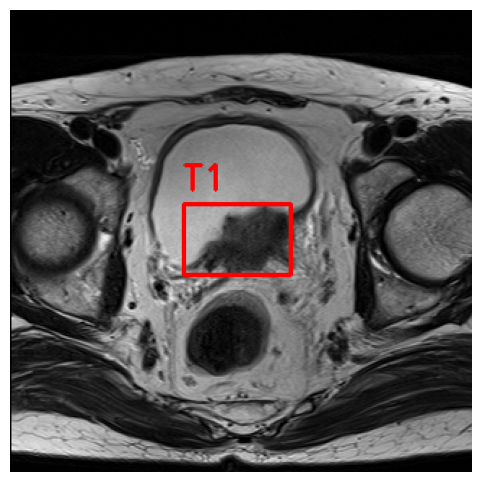

['T1', 'T1']

In [62]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from ultralytics import YOLO
import cv2
import numpy as np

# === 1. โหลด YOLO segmentation model ===
yolo_model = YOLO("best.pt")  # สำหรับตรวจจับก้อนเนื้อ

# === 2. โหลด classification model (VGG19) ===
vgg19_path = r"C:\wwwwd\vgg19_web_model.pt"
class_names = ["T1","T2","T3","T4"]
vgg19 = torch.load(vgg19_path, map_location='cpu')
vgg19.eval()

# === 3. Transform สำหรับ VGG19 ===
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# === 4. ฟังก์ชัน detect + classify + draw box + label พร้อม logits debug ===
def detect_and_predict_fixed(image_path):
    image = np.array(Image.open(image_path).convert("RGB"))
    orig_image = image.copy()

    # YOLO detect
    results = yolo_model(image)
    boxes = results[0].boxes.xyxy.cpu().numpy()  # [x1, y1, x2, y2]

    predicted_labels = []

    for idx, box in enumerate(boxes):
        x1,y1,x2,y2 = map(int, box)
        roi = image[y1:y2, x1:x2]

        if roi.size == 0:  # ป้องกัน ROI ว่าง
            continue

        # Resize ROI ให้ตรงกับ VGG19
        roi_pil = Image.fromarray(roi).resize((224,224))
        roi_tensor = transform(roi_pil).unsqueeze(0)  # batch dimension

        # Classification
        with torch.no_grad():
            outputs = vgg19(roi_tensor)
            # print logits ของแต่ละ class เพื่อ debug
            print(f"ROI {idx+1} logits:", outputs.numpy() if isinstance(outputs, np.ndarray) else outputs.cpu().numpy())
            _, pred = torch.max(outputs, 1)
            predicted_class = class_names[pred.item()]
            predicted_labels.append(predicted_class)

        # วาดกรอบและ label
        cv2.rectangle(orig_image, (x1,y1), (x2,y2), (255,0,0), 2)
        cv2.putText(orig_image, predicted_class, (x1, max(0,y1-10)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0,0), 2)

    # แสดงภาพ
    plt.figure(figsize=(6,6))
    plt.imshow(orig_image)
    plt.axis('off')
    plt.show()

    return predicted_labels

# === 5. ทดสอบภาพตัวอย่าง ===
test_image = r"C:\wwwwd\Center New\T2\muscle_0_1 62.png"
detect_and_predict_fixed(test_image)
